<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Evaluation-of-metadata-predictions" data-toc-modified-id="Evaluation-of-metadata-predictions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Evaluation of metadata predictions</a></span></li><li><span><a href="#Set-up" data-toc-modified-id="Set-up-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Set-up</a></span><ul class="toc-item"><li><span><a href="#Load-necessary-packages" data-toc-modified-id="Load-necessary-packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load necessary packages</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load data</a></span><ul class="toc-item"><li><span><a href="#Load-embedding-model" data-toc-modified-id="Load-embedding-model-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Load embedding model</a></span></li><li><span><a href="#Create-dataframe" data-toc-modified-id="Create-dataframe-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Create dataframe</a></span></li></ul></li></ul></li><li><span><a href="#Prediction-performance" data-toc-modified-id="Prediction-performance-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prediction performance</a></span><ul class="toc-item"><li><span><a href="#Covert-to-lower-case-for-better-comparison" data-toc-modified-id="Covert-to-lower-case-for-better-comparison-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Covert to lower case for better comparison</a></span></li><li><span><a href="#Overall-prediction-stats" data-toc-modified-id="Overall-prediction-stats-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Overall prediction stats</a></span></li><li><span><a href="#Exact-matches" data-toc-modified-id="Exact-matches-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Exact matches</a></span></li><li><span><a href="#Contained-within" data-toc-modified-id="Contained-within-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Contained within</a></span></li><li><span><a href="#Cosine-similarity" data-toc-modified-id="Cosine-similarity-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Cosine similarity</a></span></li><li><span><a href="#-Table-1--accuracy-of-prediction" data-toc-modified-id="-Table-1--accuracy-of-prediction-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span><font color="red"> Table 1 </font> accuracy of prediction</a></span><ul class="toc-item"><li><span><a href="#BLEU-scoring" data-toc-modified-id="BLEU-scoring-3.6.1"><span class="toc-item-num">3.6.1&nbsp;&nbsp;</span>BLEU scoring</a></span></li><li><span><a href="#Levenshtein-distance" data-toc-modified-id="Levenshtein-distance-3.6.2"><span class="toc-item-num">3.6.2&nbsp;&nbsp;</span>Levenshtein distance</a></span></li></ul></li></ul></li><li><span><a href="#Examples-of-misses?" data-toc-modified-id="Examples-of-misses?-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Examples of misses?</a></span></li></ul></div>

# Evaluation of metadata predictions
Adam Klie<br>
12/08/2019<br>
Script to evaluate predictions

# Set-up

## Load necessary packages

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import Levenshtein

from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

/cellar/users/aklie/opt/miniconda3/envs/PredictMEE_new/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/aklie/opt/miniconda3/envs/PredictMEE_new/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
/cellar/users/aklie/opt/miniconda3/envs/PredictMEE_new/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/aklie/opt/miniconda3/envs/PredictMEE_new/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


## Load data

### Load embedding model

In [2]:
nlp = spacy.load('../data/wikipedia-pubmed-and-PMC-w2v')

/cellar/users/aklie/opt/miniconda3/envs/PredictMEE_new/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/aklie/opt/miniconda3/envs/PredictMEE_new/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


### Create dataframe

In [3]:
model_iter = '11_class'

In [4]:
grouping = pd.read_csv('../results/embedding/{model}/0.8_entity_merging.csv'.format(model=model_iter), index_col=0)

In [5]:
groups = grouping[grouping["I"] == 0]["GroupName"].values

In [186]:
trial_num = 10

In [187]:
import warnings
warnings.filterwarnings('ignore')
validation_data_count = {}
merged = pd.DataFrame()
total_count = 0
for group in groups:
    group_dir = group.replace(' ', '_')
    group_dir = group_dir.replace('/', '_')
    #if group == "Platform":
    #    continue
    predicted_df = pd.read_pickle(
    '../results/prediction/{mymodel}/revision/trial_{trial}/{trial}_{myclass}_prediction.pickle'.format(mymodel = model_iter, 
                                                                          trial = trial_num, myclass = group_dir))
    class_validation = pd.read_pickle(
    '../results/validation/{mymodel}/{myclass}_validation_values.pickle'.format(mymodel = model_iter, 
                                                                                myclass = group_dir))
    validation_data = pd.read_pickle(
    '../results/validation/{mymodel}/{myclass}_validation_set.pickle'.format(mymodel = model_iter, 
                                                                             myclass = group_dir))
    class_df = predicted_df[predicted_df['predicted'] == group]
    print(group, ":", validation_data.shape[0], ",", class_df.shape[0])
    validation_data_count[group] = validation_data.shape[0]
    tmp_df = class_validation.loc[class_df['srs'].values]
    tmp_df = tmp_df.loc[~tmp_df.index.duplicated(keep = 'first')]
    class_df['actual'] = tmp_df.loc[class_df['srs'].values]['value'].values
    merged = pd.concat([merged, class_df], axis=0)
    total_count = total_count + validation_data.shape[0]

Species : 1000 , 866
Strain : 1000 , 339
Cell type : 702 , 301
Genotype : 595 , 97
Condition/Disease : 122 , 26
Tissue : 1000 , 290
Sex : 190 , 24
Age : 1000 , 231
Data type : 78 , 16
Platform : 275 , 21
Protocol : 18 , 0


# Prediction performance

## Covert to lower case for better comparison

In [188]:
merged["token"] = merged["token"].str.lower()
merged["actual"] = merged["actual"].str.lower()

## Overall prediction stats

In [189]:
predicted_count = merged.shape[0]
print(('%d/%d (%.2f%%) predicted' % 
       (predicted_count, total_count, predicted_count/total_count*100)))

2211/5980 (36.97%) predicted


In [190]:
merged["predicted"].value_counts()

Species              866
Strain               339
Cell type            301
Tissue               290
Age                  231
Genotype              97
Condition/Disease     26
Sex                   24
Platform              21
Data type             16
Name: predicted, dtype: int64

In [191]:
# missing_df = class_validation[~class_validation.index.isin(class_df['srs'].values)]
# missing = validation_data[~validation_data.index.get_level_values(0).isin(class_df['srs'].values)]
# if missing_df.shape[0] == len(missing):  # if there are not duplicate srs predictions
#     missing_df['TITLE'] = missing.values

In [192]:
# missing_df.to_csv(
#     '../results/{model}/predictions/{myclass}_missing.csv'.format(model = model_iter, myclass = predicted_class))

## Exact matches

In [193]:
merged["exact_match"] = merged['token'] == merged['actual']

In [194]:
num_correct = merged["exact_match"].sum()
print(('%d/%d (%.2f%%) exact matches' % 
       (num_correct, predicted_count, num_correct/predicted_count*100)))

503/2211 (22.75%) exact matches


In [195]:
class_exact = merged.groupby(['predicted', 'exact_match']).size().reset_index().pivot(index='predicted', 
                                                                                      columns='exact_match')
class_exact

0       
exact_match        False  True 
predicted                      
Age                193.0   38.0
Cell type          283.0   18.0
Condition/Disease   13.0   13.0
Data type           16.0    NaN
Genotype            77.0   20.0
Platform            19.0    2.0
Sex                 24.0    NaN
Species            525.0  341.0
Strain             316.0   23.0
Tissue             242.0   48.0

In [196]:
merged.groupby('exact_match').mean()["score"]

exact_match
False    0.432951
True     0.535587
Name: score, dtype: float32

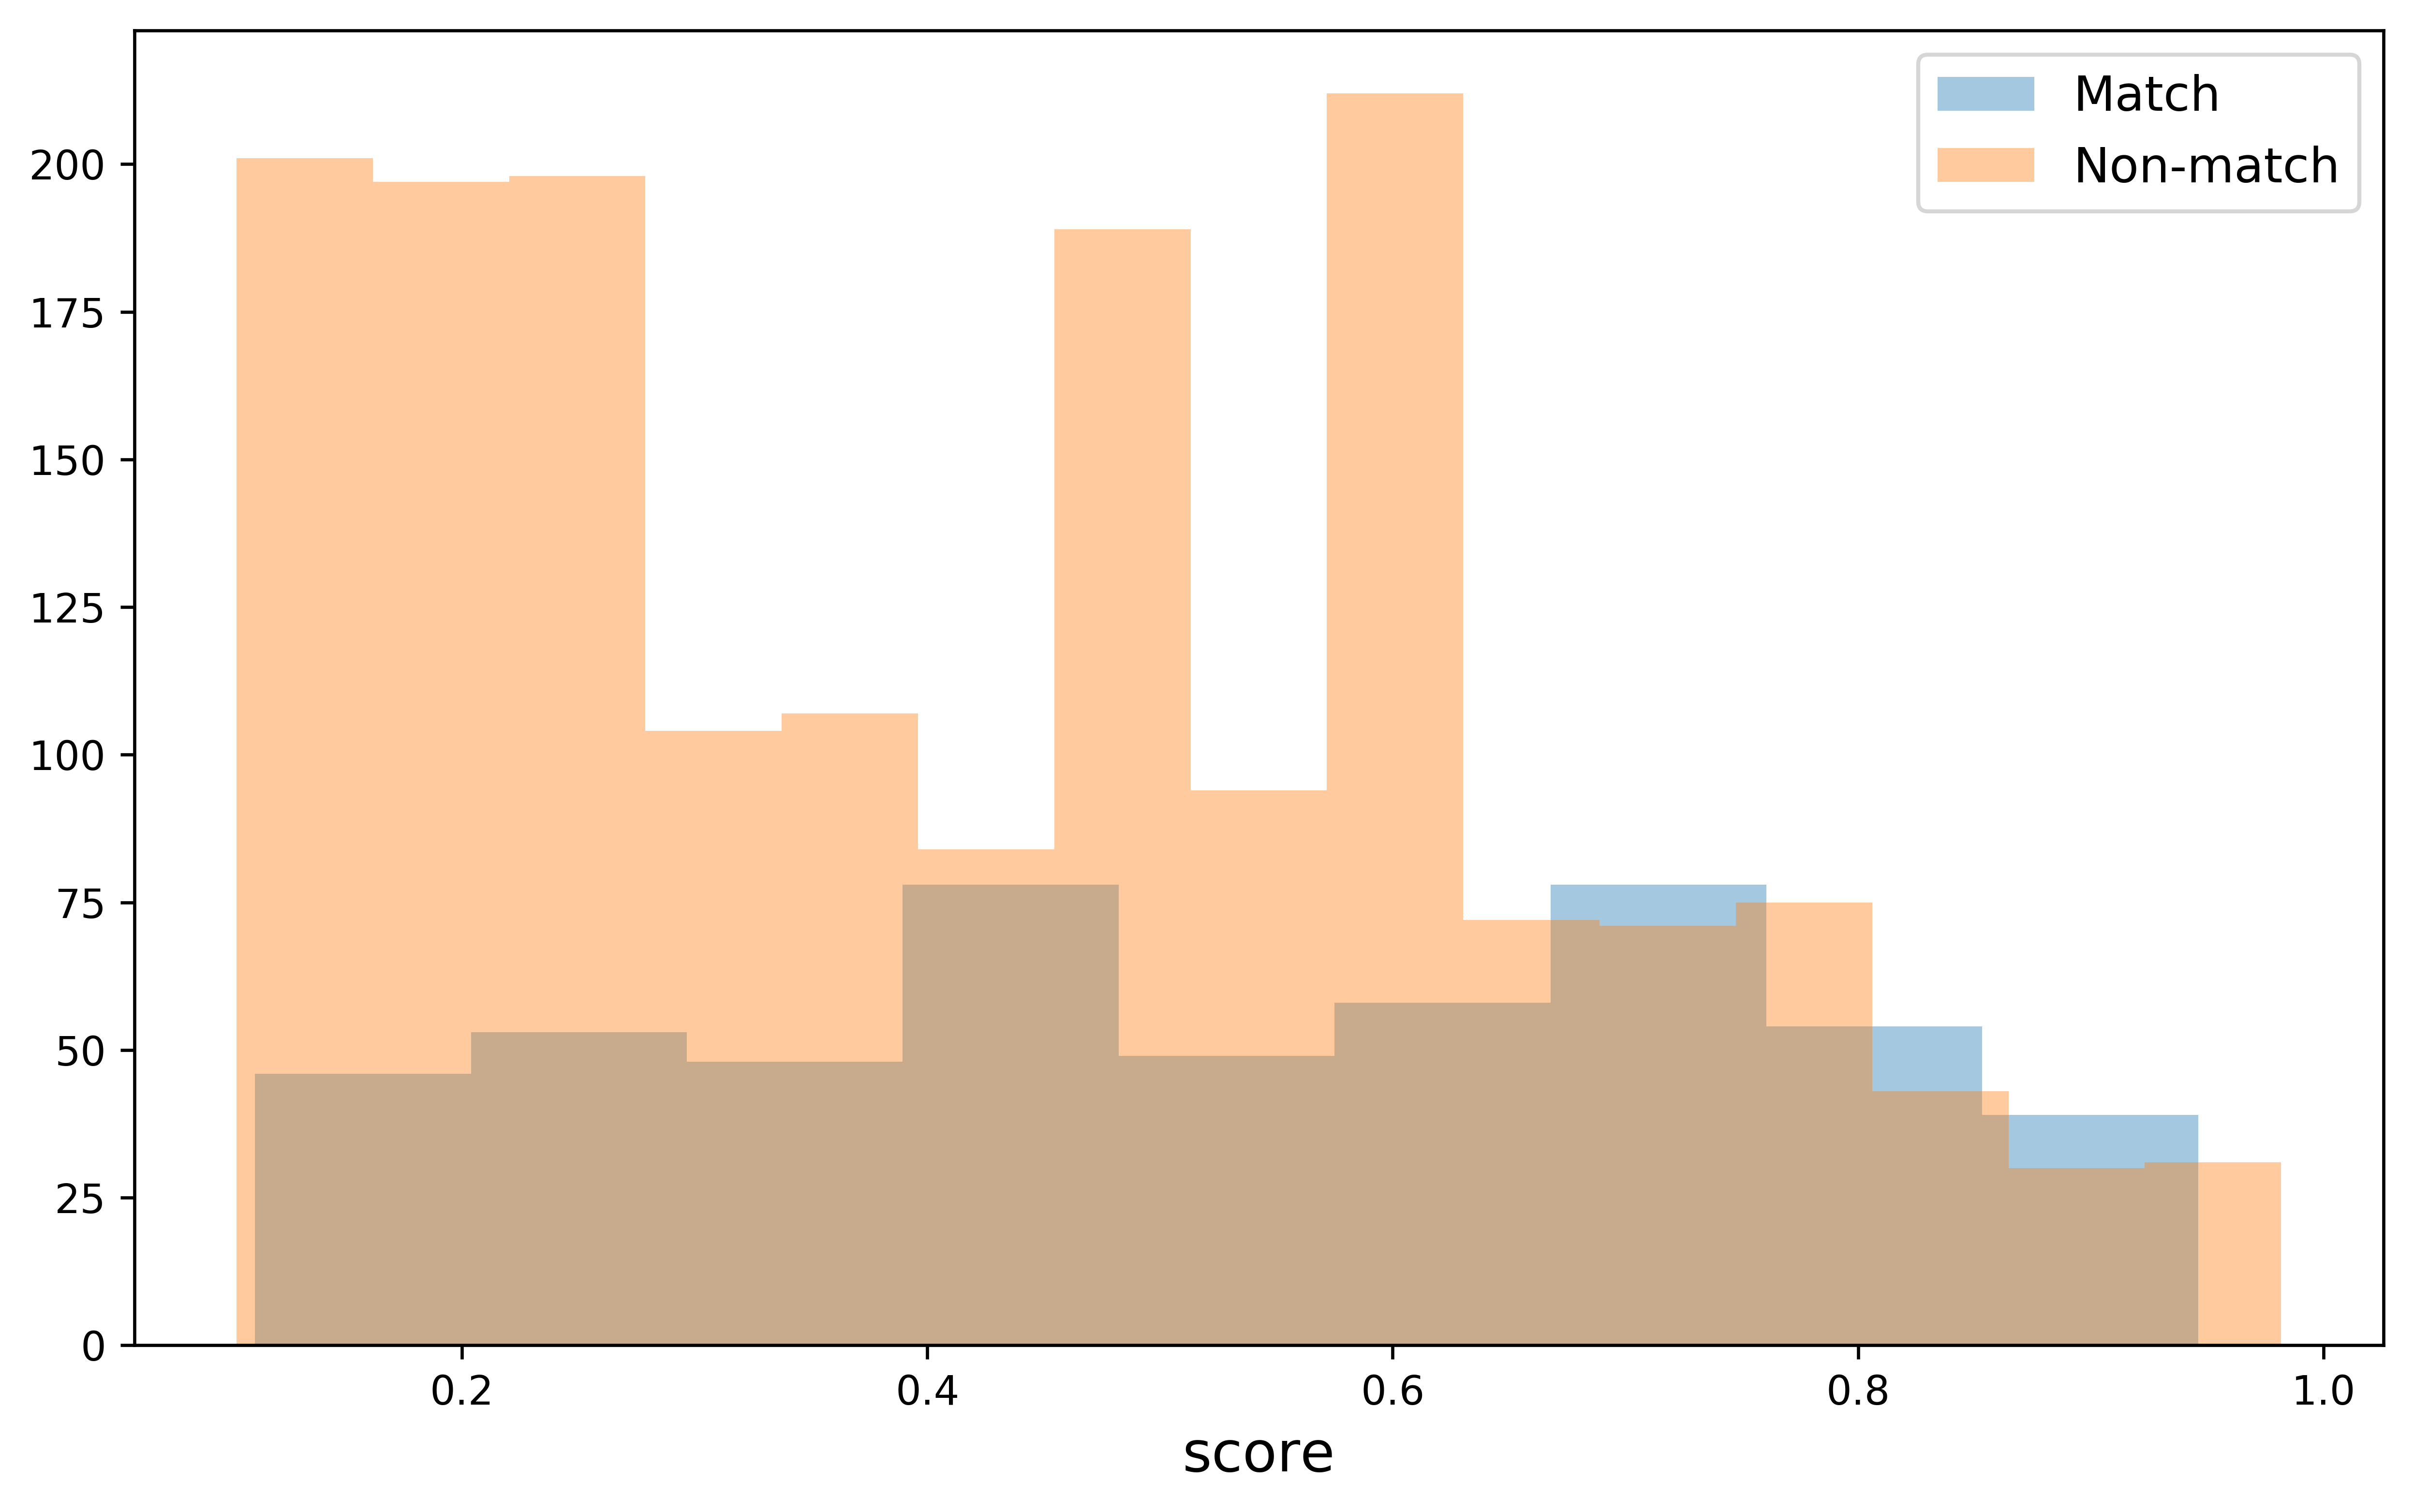

In [197]:
sns.distplot(merged[merged['exact_match'] == True]['score'], label='Match', kde=False)
sns.distplot(merged[merged['exact_match'] == False]['score'], label='Non-match', kde=False)
plt.legend(prop={'size': 12})

In [198]:
# exact_correct_df.to_csv(
#     '../results/{model}/predictions/{myclass}_correct.csv'.format(model = model_iter, myclass = predicted_class))
# exact_incorrect_df.to_csv(
#     '../results/{model}/predictions/{myclass}_incorrect.csv'.format(model = model_iter, myclass = predicted_class))

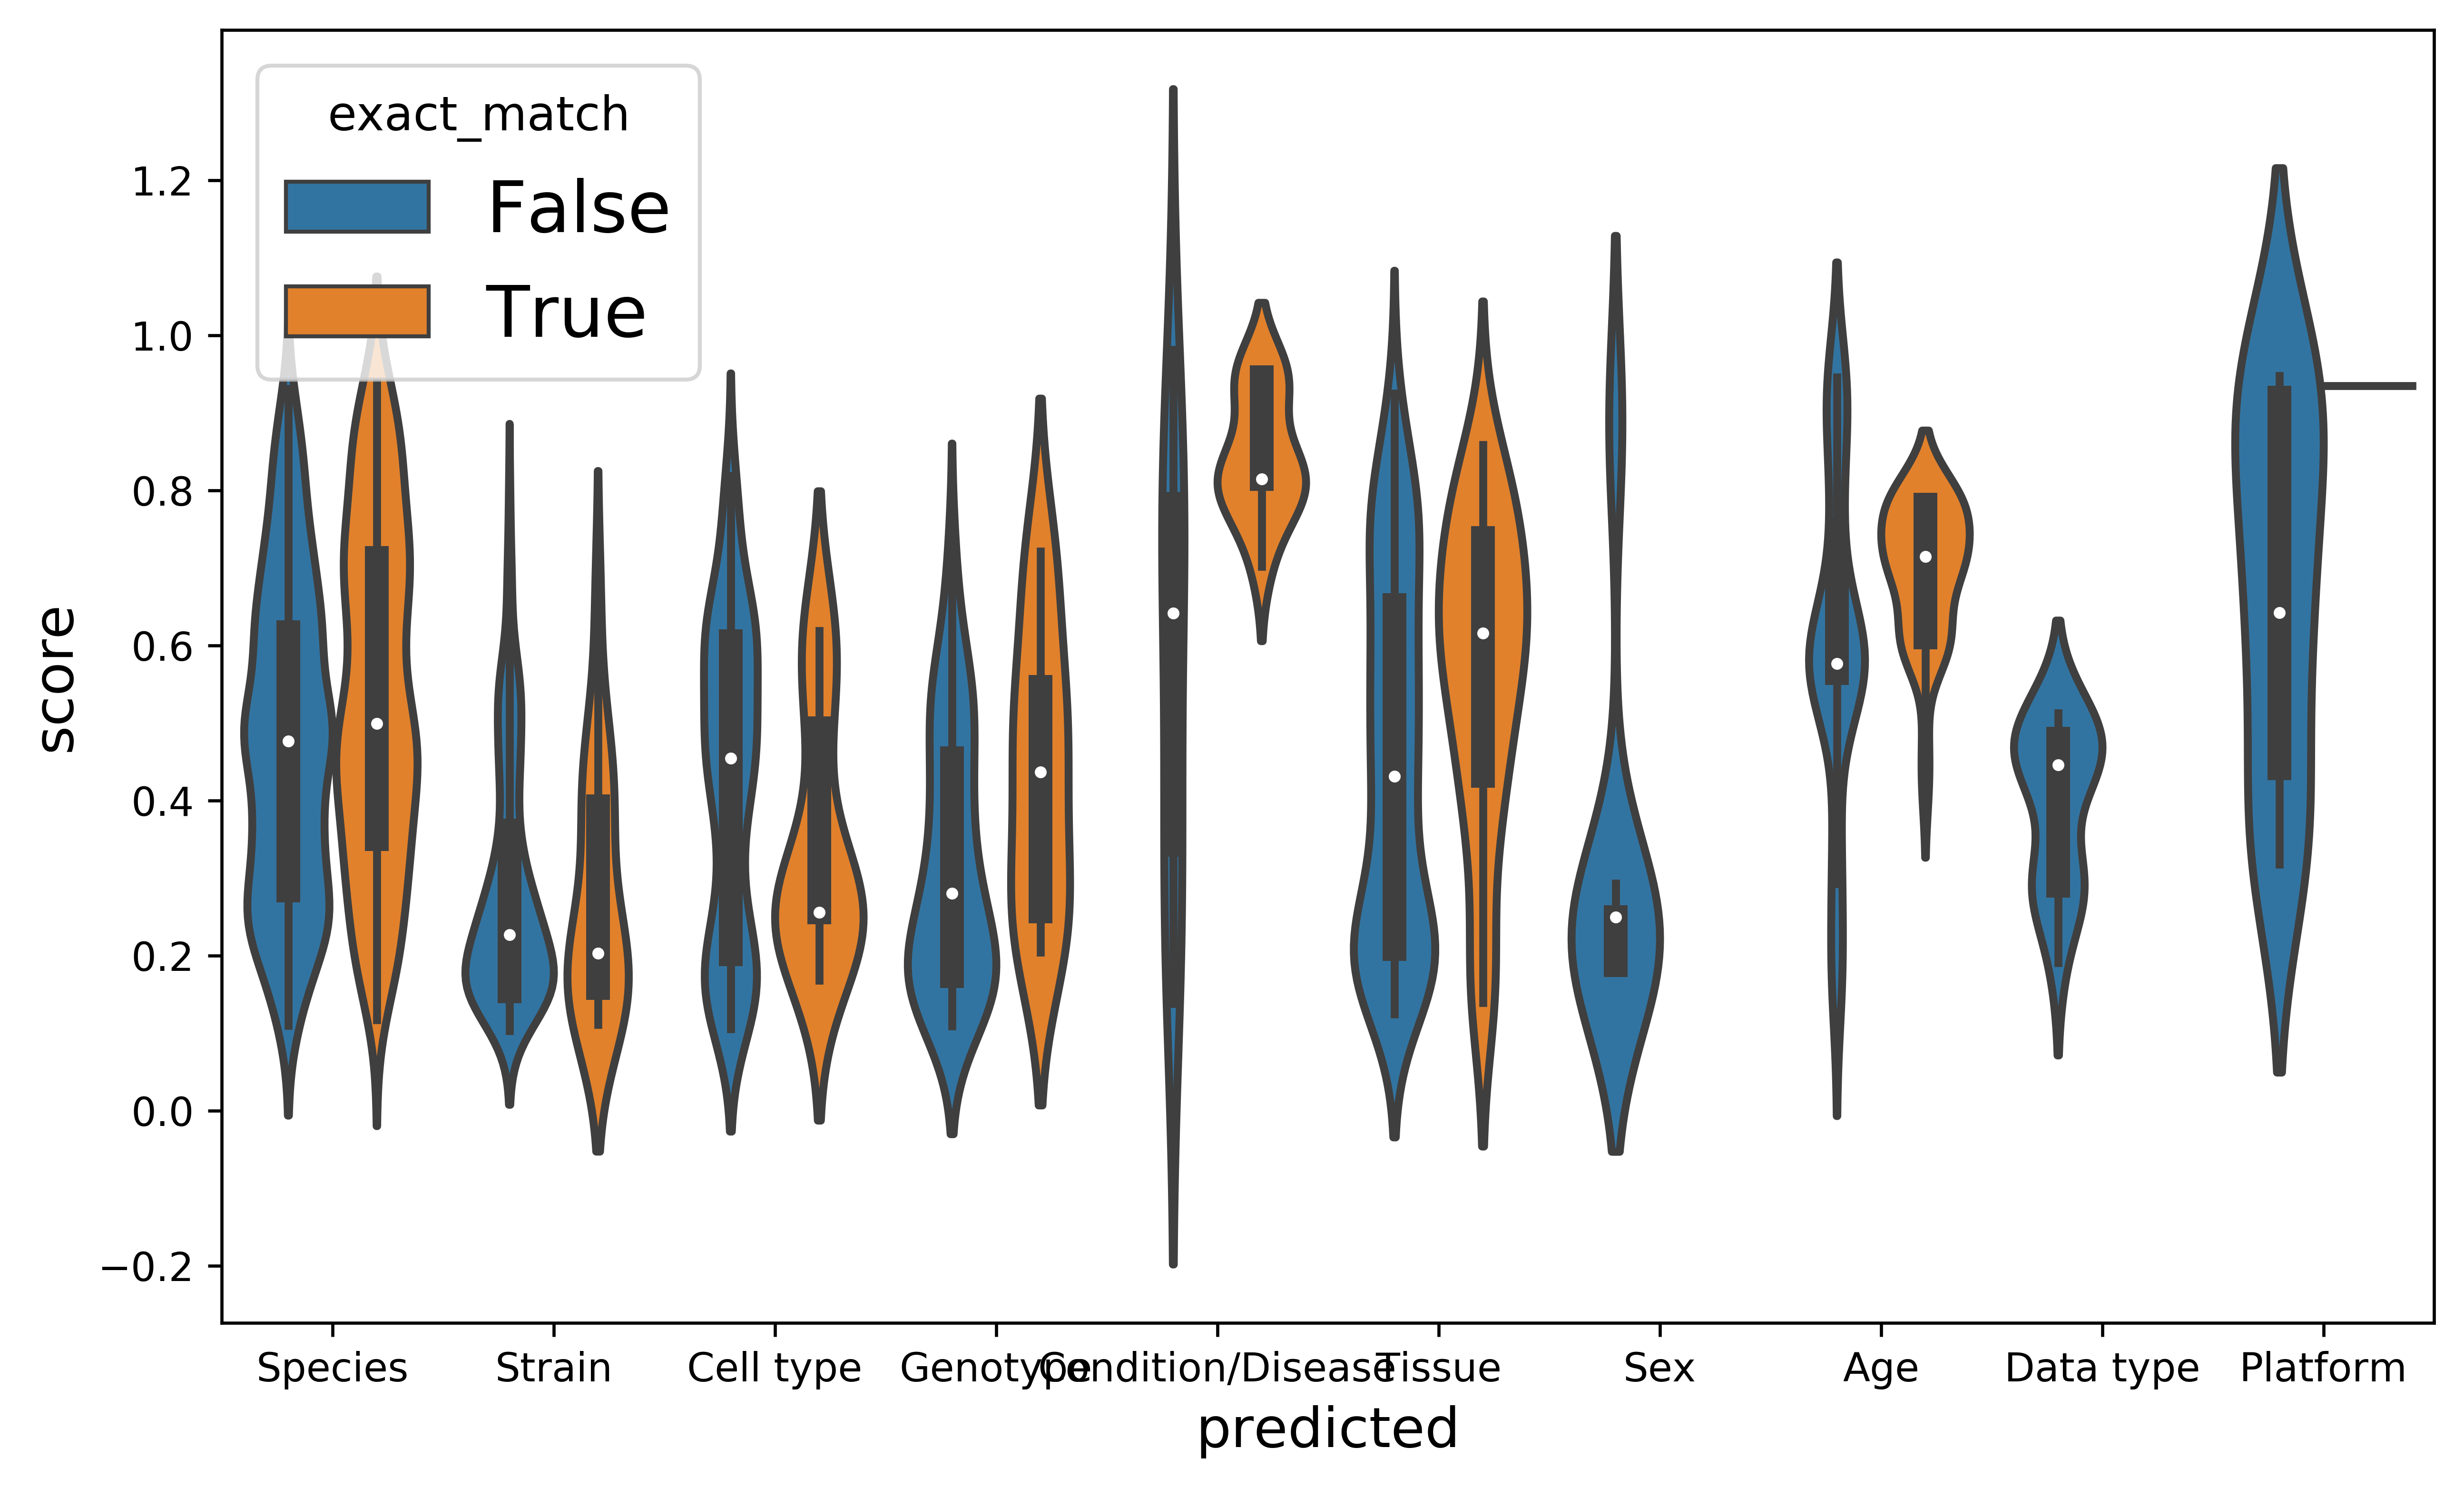

In [199]:
ax = sns.violinplot(x='predicted', y='score', data=merged, hue='exact_match')

## Contained within

In [200]:
def within(x):
    if (x["actual"] in x['token']) or (x['token'] in x["actual"]):
        return True
    else:
        return False

In [201]:
merged['within'] = merged.apply(within, axis=1)
count = merged['within'].sum()

In [202]:
print(('%d/%d (%.2f%%) of predicted contained in actual' % 
       (count, predicted_count, count/predicted_count*100)))

1455/2211 (65.81%) of predicted contained in actual


In [203]:
class_contain = merged.groupby(['predicted', 'within']).size().reset_index().pivot(index='predicted', 
                                                                                      columns='within')
class_contain.columns = ["non-match", "match"]
class_contain["fraction_match"] = class_contain["match"]/class_contain.sum(axis=1)

In [204]:
class_contain

,non-match,match,fraction_match
predicted,,,
Age,165.0,66.0,0.285714
Cell type,192.0,109.0,0.362126
Condition/Disease,6.0,20.0,0.769231
Data type,16.0,NaN,NaN
Genotype,60.0,37.0,0.381443
Platform,12.0,9.0,0.428571
Sex,3.0,21.0,0.875000
Species,107.0,759.0,0.876443
Strain,68.0,271.0,0.799410


## Cosine similarity

In [205]:
predicted_docs = nlp.pipe(merged['token'].tolist())
predicted_vectors = np.array([doc.vector for doc in predicted_docs])

actual_docs = nlp.pipe(merged['actual'].tolist())
actual_vectors = np.array([doc.vector for doc in actual_docs])

In [206]:
similarities = []
for i in range(len(predicted_vectors)):
    cosine_sim = cosine_similarity(predicted_vectors[i].reshape(1,200), actual_vectors[i].reshape(1,200))
    similarities.append(float(cosine_sim))

In [207]:
merged["cosine_similarity"] = similarities

(array([365., 121.,  87.,  68.,  55.,  57.,  78., 154., 249., 977.]),
 array([-0.09775902,  0.01201691,  0.12179283,  0.23156876,  0.34134469,
         0.45112061,  0.56089654,  0.67067246,  0.78044839,  0.89022431,
         1.00000024]),
 <a list of 10 Patch objects>)

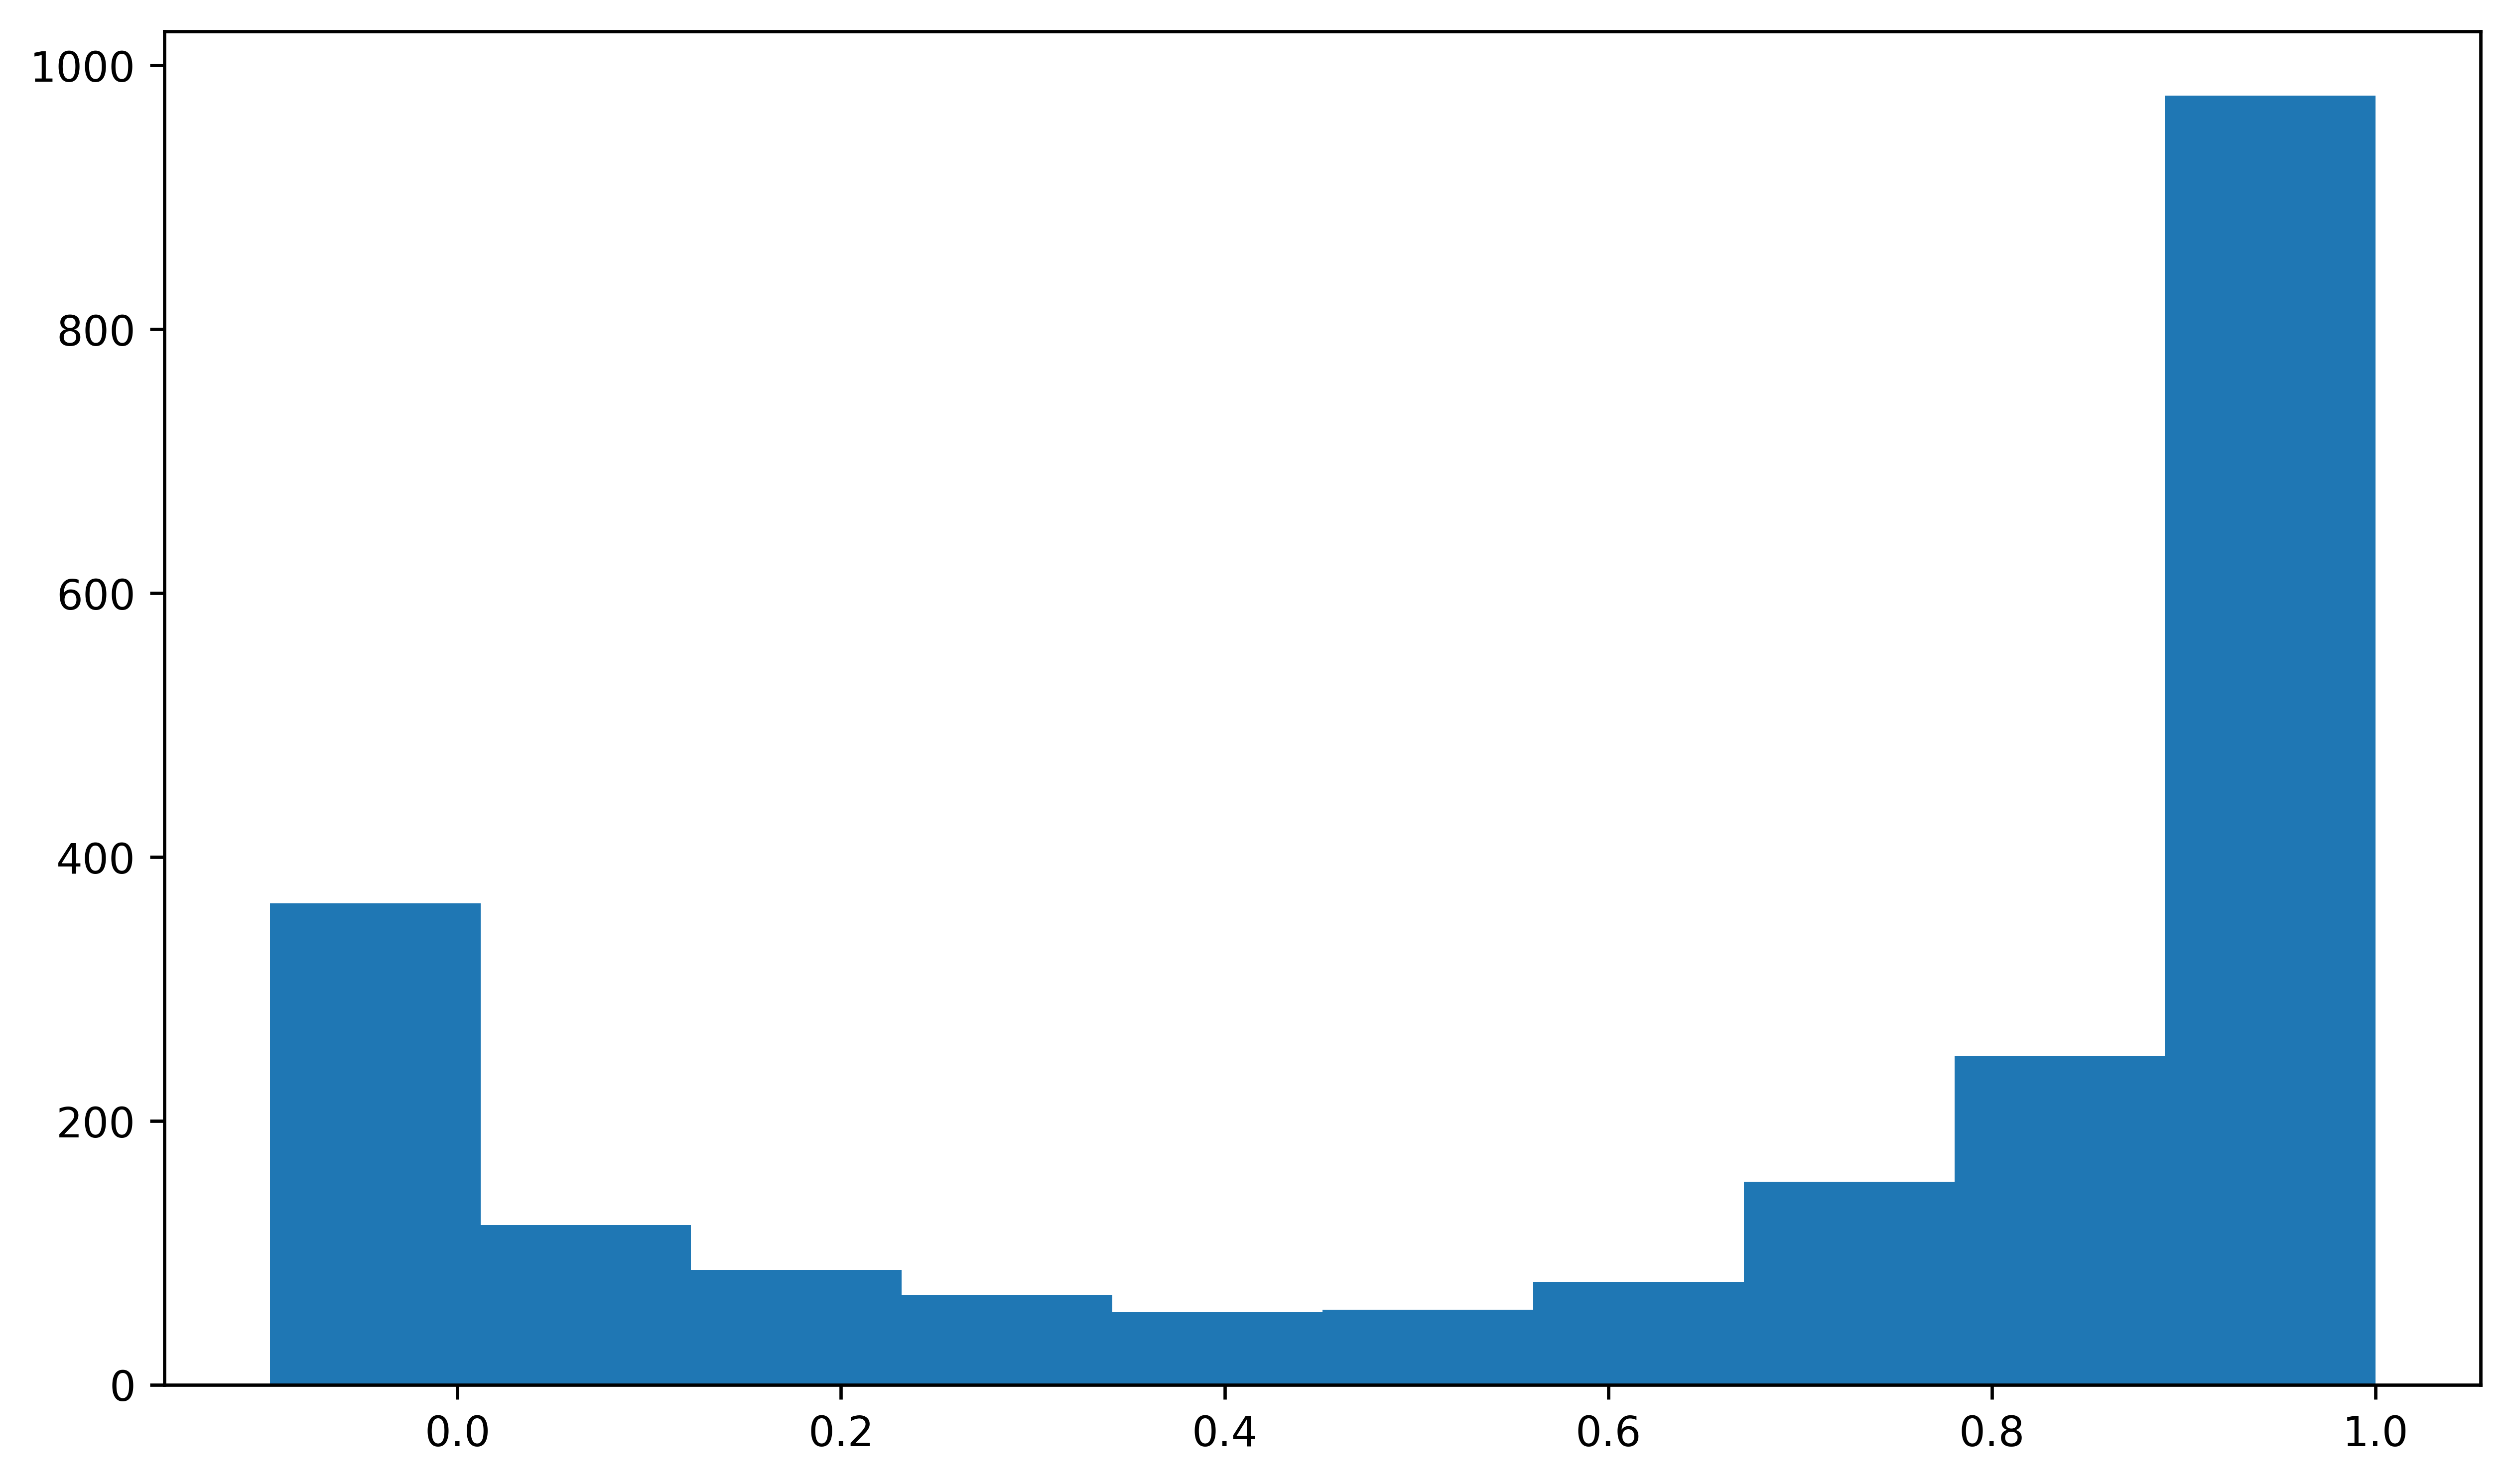

In [208]:
plt.hist(merged['cosine_similarity'])

In [209]:
sim_thresholds = np.arange(0, 1, 0.01)
performances = []
for sim_threshold in sim_thresholds:
    merged["cosine_match"] = np.abs(merged['cosine_similarity'].values) >= sim_threshold
    num_sim = merged["cosine_match"].sum()
    performances.append(num_sim/predicted_count*100)

In [210]:
from matplotlib import rcParams
import matplotlib as mpl

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 600 
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 18
rcParams['patch.edgecolor'] = 'white'
#rcParams['font.family'] = 'StixGeneral'
rcParams['pdf.fonttype'] = 42
rcParams['axes.labelsize'] = 14
rcParams['ytick.labelsize'] = 10
rcParams['xtick.labelsize'] = 10

Text(0,0.5,'% Correct')

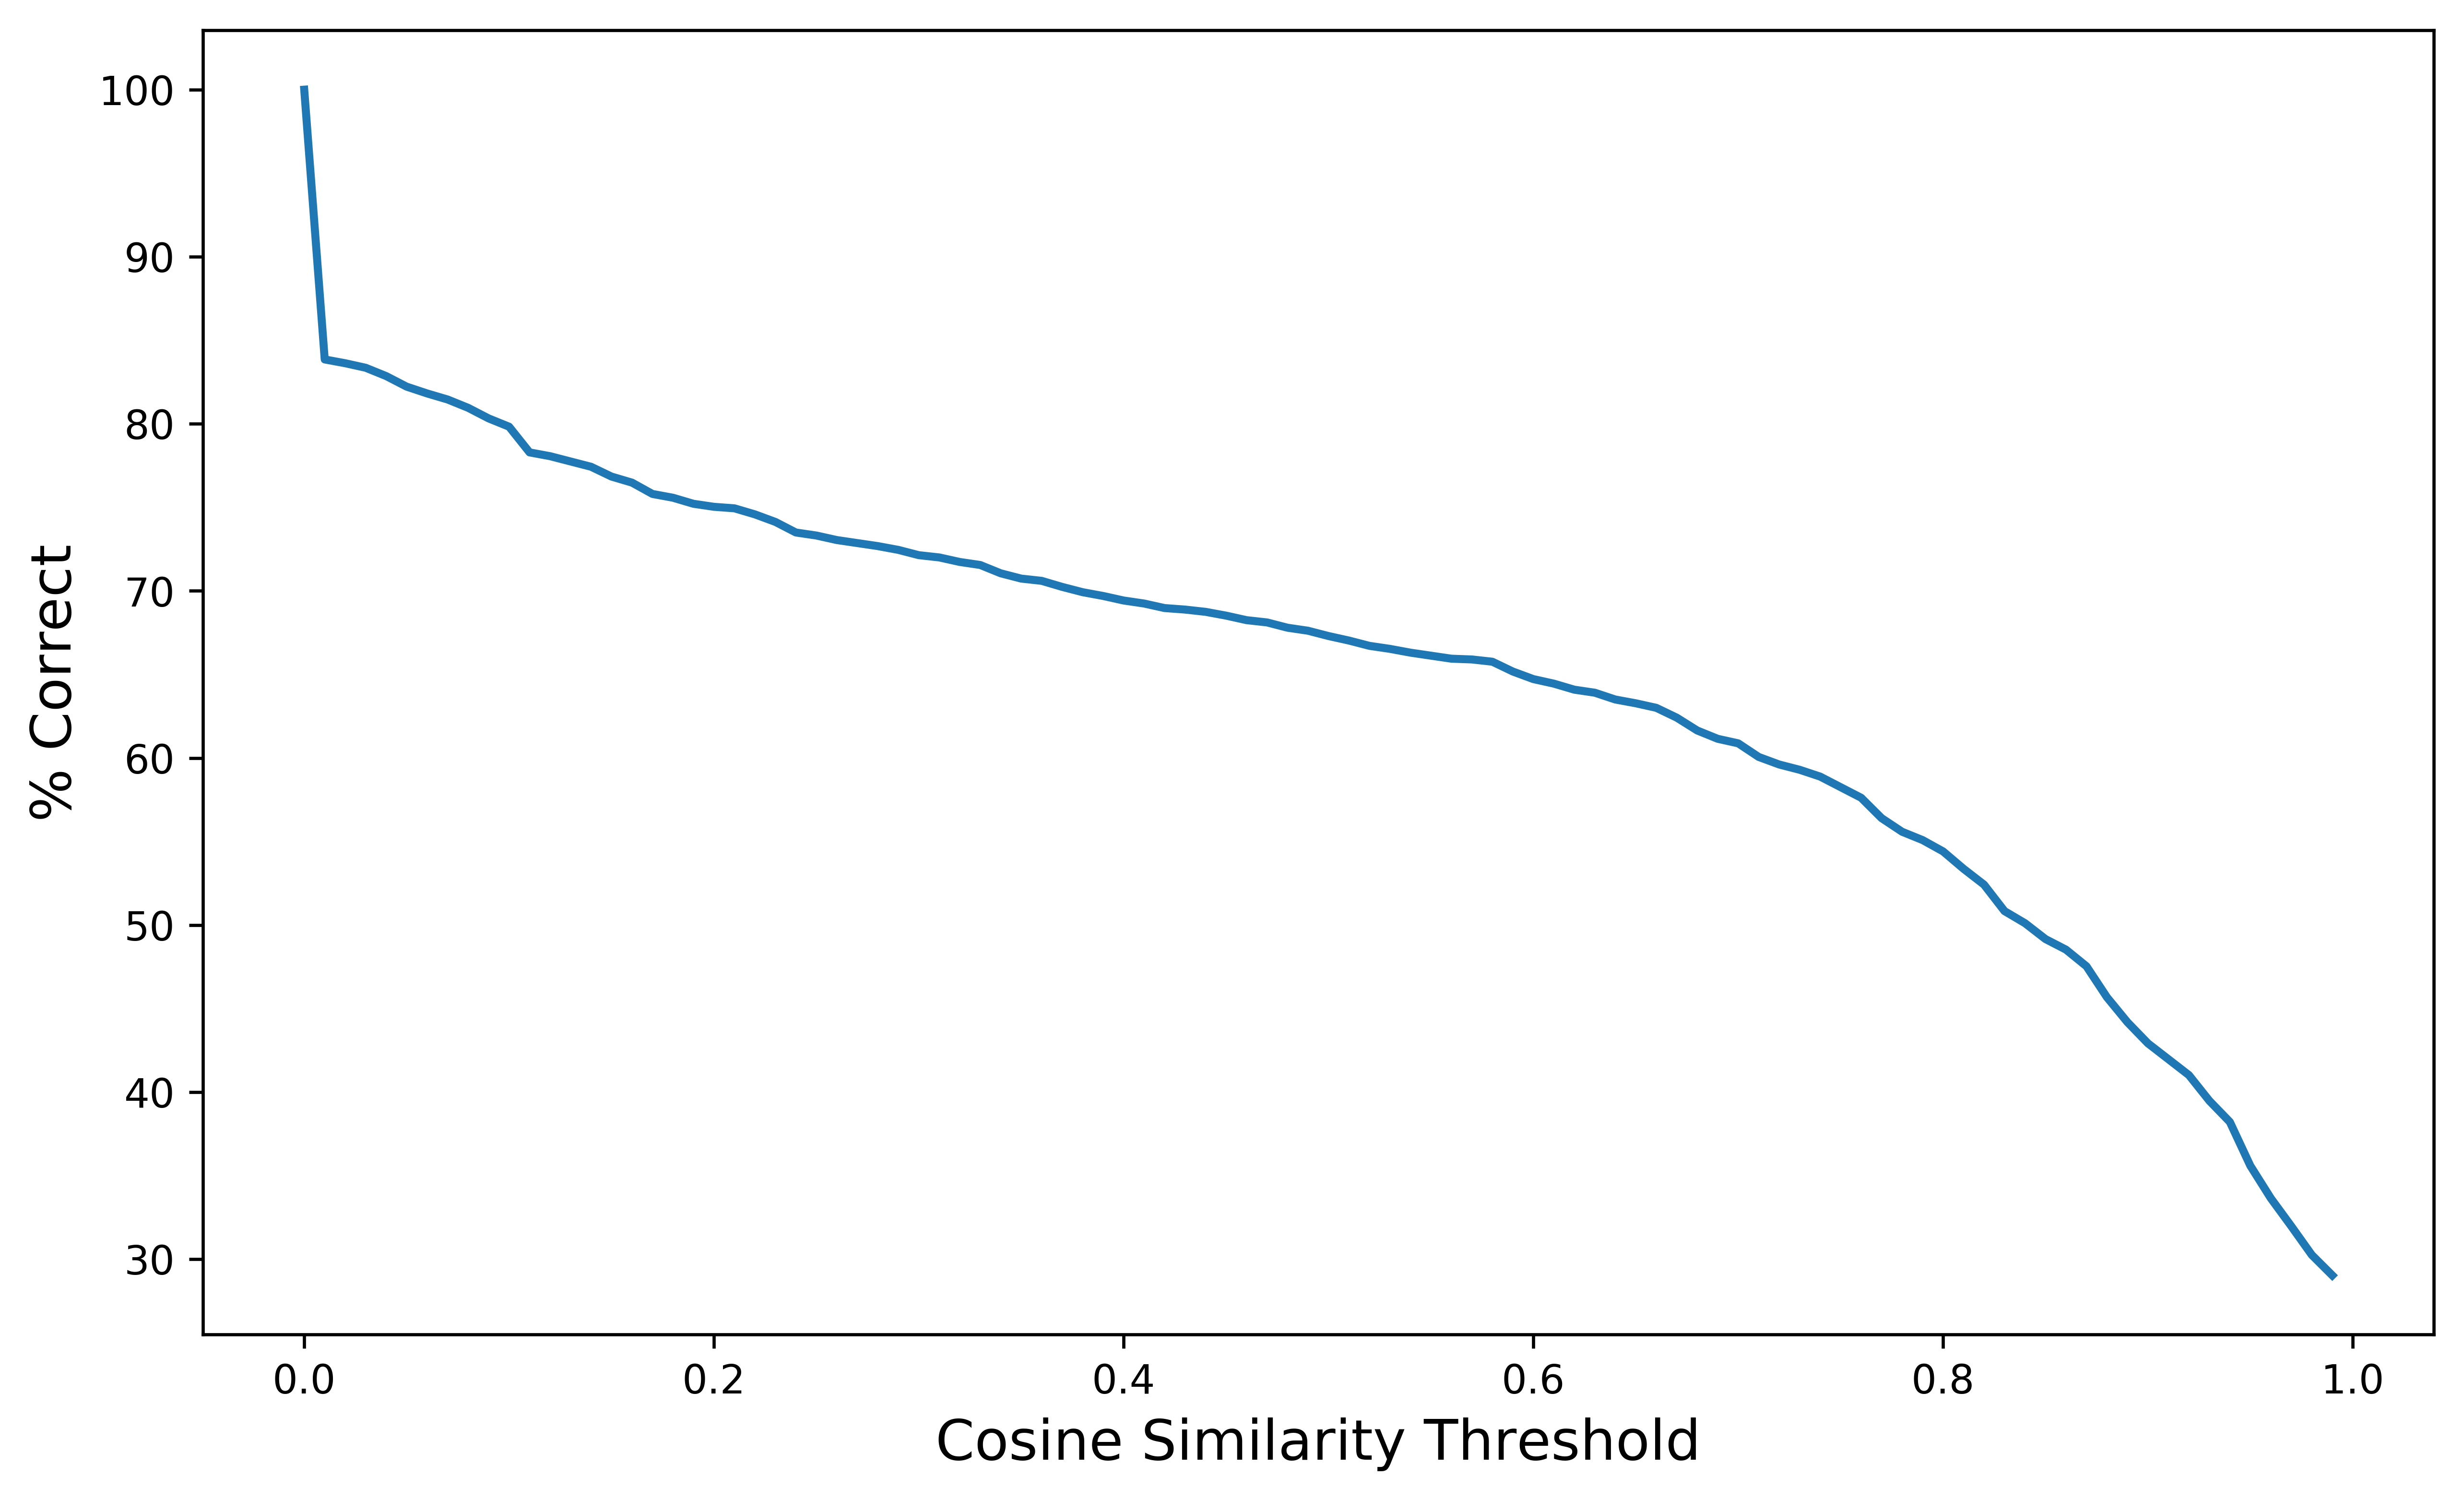

In [211]:
plt.plot(sim_thresholds, performances)
plt.xlabel('Cosine Similarity Threshold')
plt.ylabel('% Correct')

In [212]:
sim_threshold = 0.7
merged["cosine_match"] = merged['cosine_similarity'].values > sim_threshold
num_sim = merged["cosine_match"].sum()

In [213]:
print(('%d/%d (%.2f%%) Predicted with cosine similarity greater than %.1f\n' 
                     % (num_sim, predicted_count, num_sim/predicted_count*100, sim_threshold)))

1346/2211 (60.88%) Predicted with cosine similarity greater than 0.7



In [214]:
class_cosine = merged.groupby(['predicted', 'cosine_match']).size().reset_index().pivot(index='predicted', 
                                                                                        columns='cosine_match')
class_cosine.columns = ["non-match", "match"]
class_cosine["fraction_match"] = class_cosine["match"]/class_cosine.sum(axis=1)

In [215]:
class_cosine

,non-match,match,fraction_match
predicted,,,
Age,127.0,104.0,0.450216
Cell type,182.0,119.0,0.395349
Condition/Disease,5.0,21.0,0.807692
Data type,7.0,9.0,0.562500
Genotype,42.0,55.0,0.567010
Platform,10.0,11.0,0.523810
Sex,NaN,24.0,1.000000
Species,64.0,802.0,0.926097
Strain,311.0,28.0,0.082596


In [216]:
title_counts = pd.DataFrame(pd.Series(validation_data_count), columns=['titles'])

## <font color='red'> Table 1 </font> accuracy of prediction

In [217]:
merged["either"] = merged["within"] | merged["cosine_match"]

In [218]:
class_either = merged.groupby(['predicted', 'either']).size().reset_index().pivot(index='predicted', 
                                                                                        columns='either')
class_either.columns = ["non-match", "match"]
class_either["either_match"] = class_either["match"]/class_either.sum(axis=1)

In [219]:
class_either

,non-match,match,either_match
predicted,,,
Age,124.0,107.0,0.463203
Cell type,166.0,135.0,0.448505
Condition/Disease,4.0,22.0,0.846154
Data type,7.0,9.0,0.562500
Genotype,36.0,61.0,0.628866
Platform,10.0,11.0,0.523810
Sex,NaN,24.0,1.000000
Species,53.0,813.0,0.938799
Strain,67.0,272.0,0.802360


In [220]:
table1 = class_cosine.merge(pd.DataFrame(merged["predicted"].value_counts()), left_index=True, right_index=True)
table1 = table1.merge(title_counts, left_index=True, right_index=True)
table1 = table1.merge(class_contain, left_index=True, right_index=True, suffixes=['_cosine', '_contain'])
table1 = table1.merge(class_either, left_index=True, right_index=True, suffixes=['_either', '_either'])

In [221]:
table1["fraction_predicted"] = table1['predicted']/table1['titles']

In [222]:
table1 = table1[['titles', 'predicted', 'fraction_predicted', 
        'match_cosine', 'fraction_match_cosine', 'match_contain', 'fraction_match_contain', 'match', 'either_match']]

In [223]:
table1['percent_correct'] = table1[["fraction_match_cosine", "fraction_match_contain"]].max(axis=1)

In [224]:
table1

,titles,predicted,fraction_predicted,match_cosine,fraction_match_cosine,match_contain,fraction_match_contain,match,either_match,percent_correct
Age,1000,231,0.231000,104.0,0.450216,66.0,0.285714,107.0,0.463203,0.450216
Cell type,702,301,0.428775,119.0,0.395349,109.0,0.362126,135.0,0.448505,0.395349
Condition/Disease,122,26,0.213115,21.0,0.807692,20.0,0.769231,22.0,0.846154,0.807692
Data type,78,16,0.205128,9.0,0.562500,NaN,NaN,9.0,0.562500,0.562500
Genotype,595,97,0.163025,55.0,0.567010,37.0,0.381443,61.0,0.628866,0.567010
Platform,275,21,0.076364,11.0,0.523810,9.0,0.428571,11.0,0.523810,0.523810
Sex,190,24,0.126316,24.0,1.000000,21.0,0.875000,24.0,1.000000,1.000000
Species,1000,866,0.866000,802.0,0.926097,759.0,0.876443,813.0,0.938799,0.926097
Strain,1000,339,0.339000,28.0,0.082596,271.0,0.799410,272.0,0.802360,0.799410
Tissue,1000,290,0.290000,173.0,0.596552,163.0,0.562069,186.0,0.641379,0.596552


In [225]:
table1.to_csv('../doc/revision/reviewer_3/{}_comment_3.csv'.format(trial_num), index=True)

### BLEU scoring

In [153]:
def bleu1(x):
    return sentence_bleu(x["predicted"], x["actual"], weights=(1, 0, 0, 0), smoothing_function=smoother.method1)

def bleu4(x):
    return sentence_bleu(x["predicted"], x["actual"], weights=(0, 0, 0, 1), smoothing_function=smoother.method1)

In [154]:
smoother = SmoothingFunction()
table1["BLUE1"] = table1.apply(bleu1, axis=1)
table1["BLUE4"] = table1.apply(bleu4, axis=1)

KeyError: ('actual', 'occurred at index Age')

### Levenshtein distance

In [155]:
def levenshtein(x):
    return Levenshtein.distance(x["predicted"], x["actual"])

In [156]:
table1["levenshtein"] = table1.apply(levenshtein, axis=1)

KeyError: ('actual', 'occurred at index Age')

# Examples of misses?

In [50]:
missed = merged[~merged["either"]]
missed_df = missed[["predicted", "orig_text","recovered_txt", "actual"]]

In [51]:
missed_df.to_csv('../doc/tables/Supplementary/revision/Supp_Table3.csv')

In [60]:
((missed_df.actual.str.count(" ") + 1) == 1).sum()

217

In [61]:
missed_df

,predicted,orig_text,recovered_txt,actual
2544,Species,32% Streptococcus mutans UA159 69,Streptococcus mutans,mixed sample
2536,Species,68% Lactobacillus casei 4646,Lactobacillus casei,mixed sample
2535,Species,A cucumber genomic variation map reveals impac...,A cucumber,cucumis sativus
2403,Species,Bulk soils compared rhizosphere communities pl...,Saxifraga oppositifolia,unidentified bacterium
2400,Species,CBo1 isolated gut Bactrocera oleae,Bactrocera oleae,chryseobacterium sp. 113(2015)
2256,Species,Endophytic isolate branches Citrus sinensis,Citrus sinensis,curtobacterium sp. er1/6
2245,Species,Environmental/Metagenome sample subarctic root...,subarctic root,fungi
2066,Species,Generic sample Fusobacterium nucleatum,Fusobacterium nucleatum,fusobacterium phage funu1
2051,Species,Generic sample Homo sapiens respiratory syncyt...,Homo sapiens,human orthopneumovirus
2023,Species,Generic sample Mimulus guttatus,Mimulus guttatus,erythranthe guttata
